## 목적 : implement iterative classification algorithm to classify nodes in the e-mail exchange graph to company management levels (1,2,3)

  - [코드 출처](https://github.com/adriannaziel/CollectiveClassification_ICA/blob/master/ICA.ipynb)

In [2]:
# do not show sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import csv
import numpy as np
import pandas as pd
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score,classification_report, accuracy_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import networkx as nx
from operator import itemgetter 

In [4]:
class1 = [86, 7, 27, 36, 69, 70, 85, 104, 121, 148, 156, 163]
class2 = [76, 90, 136, 137, 143, 152, 47, 162]
#class3 - other

In [12]:
## Metadata on email communication

communication_data = pd.read_csv('/content/drive/MyDrive/EURON3기-DL/communication.csv', sep =';')  

In [13]:
## Corporate hierarchy

reportsto_data = pd.read_csv('/content/drive/MyDrive/EURON3기-DL/reportsto.csv', sep =';')  

In [14]:
## Node Class 설정

class Node:
    def __init__(self, n_id):
        self.n_id = n_id
        self.clear()
        
        
    def features(self):
        features_array = np.array([self.send, self.received, self.degree, self.betweenness, self.closeness, self.neighbors_1, self.neighbors_2, self.neighbors_3 ])
        return features_array
    
    def set_label(self,l):
        if self.label == l:
            return False
        else:
            self.label = l
            return True
        
    def set_values(self,c,b,d):
        self.degree = d
        self.betweenness = b
        self.closeness = c
    
    
    def update_neighbours(self, neighbors):
        self.neighbors_2 =0
        self.neighbors_3 =0
        self.neighbors_1 =0
        
        for n in neighbors:
            nl = n.label
            if nl ==1:
                self.neighbors_1 +=1
            elif nl ==2:
                self.neighbors_2 +=1
            elif nl ==3:
                self.neighbors_3 +=1
                
    def show(self):
        return( self.n_id, 
              self.known, 
              self.label,
              self.send,
              self.received, 
              self.degree,
              self.betweenness,
              self.closeness,
              self.neighbors_1,
              self.neighbors_2,
              self.neighbors_3)
        
    def clear(self):
        self.known = False
        self.label = -1
        self.send = 0
        self.received = 0
        self.degree = -1
        self.betweenness = -1
        self.closeness = -1
        self.neighbors_1 = 0
        self.neighbors_2 = 0
        self.neighbors_3 = 0

In [15]:
## 노드의 클래스 확인 후 반환

def check_node_value(node_nr):
    if node_nr in class1:
        return 1
    if node_nr in class2:
        return 2
    return 3

In [16]:
## 노드의 이웃 노드들 반환

def get_node_neighbours(G,n_id,all_nodes):
    node_neighbours = []
    for nn in G.neighbors(n_id):
        node_neighbours.append(all_nodes[nn])
    return node_neighbours

In [17]:
def clear_nodes(nodes):
    for n in nodes:
        nodes[n].clear()

In [18]:
## 알고 있는 것과 모르고 있는 것 반환

def select_known(N, source):
    known = [x[0] for x in list(source[:N])]
    unknown = [x[0] for x in list(source[N:])]
    return known, unknown

In [29]:
## 노드를 알고 있는지, 노드의 라벨, 노드의 centrality와 degree들, 이웃들을 설정해 노드들 값 저장

def prepare_nodes(k_nodes,betweennes,closeness,degree, nodes, G): 
    for n in k_nodes:
        node = nodes[n]
        node.known = True
        node.label = check_node_value(n)


    for n in nodes:
        node = nodes[n]
        node.set_values(closeness[n],betweennes[n],degree[n])
        node.update_neighbours(get_node_neighbours(G, n,nodes))

In [26]:
## communication dataset에 있는 sender와 recipient 값을 갖고와 노드 딕셔너리에 저장

all_nodes = {}
edges_communication_all = []

for index, row in communication_data.iterrows():
    sender_id = int(row['Sender'])
    recipient_id = int(row['Recipient'])
    
    edges_communication_all.append((sender_id,recipient_id))
    
    
    if recipient_id not in all_nodes:
        all_nodes[recipient_id] = Node(recipient_id)
        
    if sender_id not in all_nodes:
        all_nodes[sender_id]  = Node(sender_id)
        
    all_nodes[recipient_id].received +=1
    all_nodes[sender_id].send +=1

In [27]:
# 중복되는 소통, edge들은 제거

edges_communication = []
for s,r in edges_communication_all:
    if not((s,r) in edges_communication or  (r,s) in edges_communication):
        edges_communication.append((s,r))

In [28]:
## 그래프에 edge 저장

G = nx.Graph()
G.add_edges_from(edges_communication)

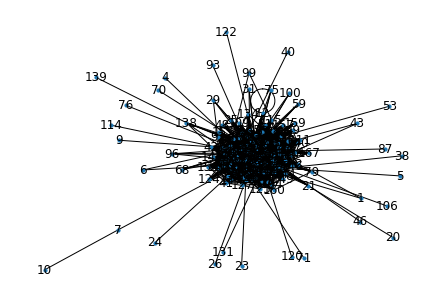

In [30]:
pos = nx.circular_layout(G)

nx.draw(G, with_labels=True, node_size=10)

In [31]:
## centrality 계산

betweenness_dict = nx.betweenness_centrality(G)
closeness_dict = nx.closeness_centrality(G)
degree_dict = dict(G.degree())
betweenness_sorted = sorted(betweenness_dict.items(), key = itemgetter(1), reverse = True) 
closeness_sorted = sorted(closeness_dict.items(), key = itemgetter(1), reverse = True)
degree_sorted = sorted(degree_dict.items(), key = itemgetter(1), reverse = True)

In [33]:
## DecisionTreeClassifier, Gaussian Naive Bayer Classifier을 훈련시키는 함수 생성

def train_classifier(k_nodes , nodes, classification_type='dt'):
    # 훈련 데이터 준비
    x_train = []
    y_train = []

    for k in k_nodes:
        n = nodes[k]
        x_train.append(n.features()) ## X_train에 노드들의 피처 저장
        y_train.append(n.label) ## Y_train에 노드들의 라벨 저장

    if classification_type == 'dt':
        classifier = DecisionTreeClassifier(random_state =2)
    elif classification_type == 'gnb':
        classifier = GaussianNB()
    else:
        raise Exception('This classification type is not available') 
        
    classifier = classifier.fit(x_train, y_train) ## 함수 훈련
    return classifier

In [34]:
## Classifier을 여러 번 돌리면서 label이 변하는 것이 있는지 확인 후 반환

def run_iterative_classification(classifier, nodes_order, nodes, max_iters = 1000, G=G):
    MAX_ITERS = max_iters
    label_changed = True
    n_iter = 0
    while label_changed and n_iter<MAX_ITERS:
        label_changed = False 
        for o in nodes_order:
            node = nodes[o]
            prev_label = node.label
            n_neighbours = get_node_neighbours(G, o,all_nodes)
            node.update_neighbours(n_neighbours)
            nf = node.features()
            n_curr_label = classifier.predict([nf])[0]
            n_changed = node.set_label(n_curr_label)
            if n_changed:
                label_changed = True
        n_iter+=1
    print('Number of iters:', n_iter)

In [35]:
## F1 SCORE와 ACCURACY 평가

def evaluate(nodes_to_evaluate, all_nodes):
    true_labels = []
    pred_labels = []
    for o in nodes_to_evaluate:
        n = all_nodes[o]
        pred_labels.append(n.label)
        true_labels.append(check_node_value(o))
    f1 = f1_score(true_labels, pred_labels, average='macro')
    accuracy = accuracy_score(true_labels, pred_labels)
    #print(classification_report(true_labels, pred_labels))
    return f1, accuracy 

In [36]:
b = betweenness_sorted
c = closeness_sorted
d = degree_sorted

In [40]:
clear_nodes(all_nodes)
known_nodes,unknown_nodes = select_known(20,d)
prepare_nodes(known_nodes, betweenness_dict, closeness_dict, degree_dict, nodes = all_nodes,G=G)
classifier = train_classifier( k_nodes = known_nodes, nodes = all_nodes)
run_iterative_classification(classifier,nodes_order = unknown_nodes,  nodes = all_nodes)
evaluate(unknown_nodes, all_nodes)

Number of iters: 2


(0.3075030750307503, 0.8503401360544217)